<h1><center>KNN Iris with Cross Validation</center></h1>

<center><img src="https://images.unsplash.com/photo-1568719284247-70e91bb55586?ixlib=rb-4.0.3&ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&auto=format&fit=crop&w=1170&q=80" alt="Iris Flower" title="Iris Flower"  style="object-fit:cover; width:800px; height:250px;"/></center>

> __*Created by Charley Lebarbier*__

## Objectifs :  

Une chaine de fleuriste aimerait pouvoir trier ses différentes espèces d'iris.

Réalisez un programme permettant de prédire l'espèce d'une iris à partir de la largeur et longueur de ses sépales et des pétales.

## Critères de performance :

•	Les données ont été analysées et il existe une trace de cette analyse exploratoire dans un jupyter-notebook  
•	Un programme qui fonctionne sans bug, et qui classifie bien les iris (vous afficherez la matrice de confusion et l'accuracy obtenus sur la base Test)


____________________________________
____________________________________

<center><h3>EDA - Analyse Exploratoire de Données</h3></center>

#### Préparation de notre environnement de travail

In [47]:
# Import Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings

from numpy import mean
from sklearn.datasets import load_iris    # Get Iris Database
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.model_selection import KFold, LeaveOneOut, ShuffleSplit 
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve, validation_curve
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

%matplotlib inline

In [48]:
# Import Iris data 
load = load_iris()

# Transform in pd.DataFrame to work on it
iris = pd.DataFrame(load['data'], 
    columns = ['Petal length','Petal Width','Sepal Length','Sepal Width'])
iris['Species'] = load['target']    # Add the 'Species' column
iris['Species'] = iris['Species'].apply(lambda x: load['target_names'][x])

# Check the first ten rows
iris.head()

,Petal length,Petal Width,Sepal Length,Sepal Width,Species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


In [49]:
# Check the missing data

iris.isnull().sum() 

Petal length    0
Petal Width     0
Sepal Length    0
Sepal Width     0
Species         0
dtype: int64

In [50]:
# Get different informations

#iris.info()
iris.describe()

,Petal length,Petal Width,Sepal Length,Sepal Width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


On peut déjà noter la moyenne pour nos différentes valeurs :
- Petal length : 5.84
- Petal Width : 3.05
- Sepal Length : 3.75
- Sepal Width : 1.19

In [51]:
# Checking the dataset output balance
iris['Species'].value_counts()

setosa        50
versicolor    50
virginica     50
Name: Species, dtype: int64

Notre jeu de données est parfaitement équilibré, il n'y a aucune target *(ici, nos 'species')* en plus grand nombre qu'une autre.

________________________
#### Analyse des données

Le dataset préparé et les premières informations recueillies, notamment sur l'équilibre de celui-ci, nous pouvons commencer notre exploration par une visualisation des corrélations entre les différentes caractéristiques.

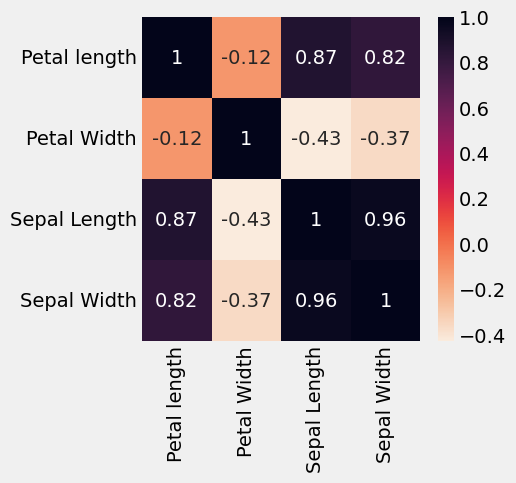

In [52]:
plt.figure(figsize=(4, 4))
sns.heatmap(iris.corr(), cmap='rocket_r', annot=True)
plt.show()

La corrélation nous révèle qu'il y a trois fortes corrélations positives :
- Petal Length / Sepal Length (0.87)
- Petal Length / Sepal Width (0.82)
- Sepal Length / Sepal Width (0.96)

et deux corrélations négatives faibles (-0,43, -0,37)

On va choisir de concentrer notre analyse sur ces corrélations fortes positives

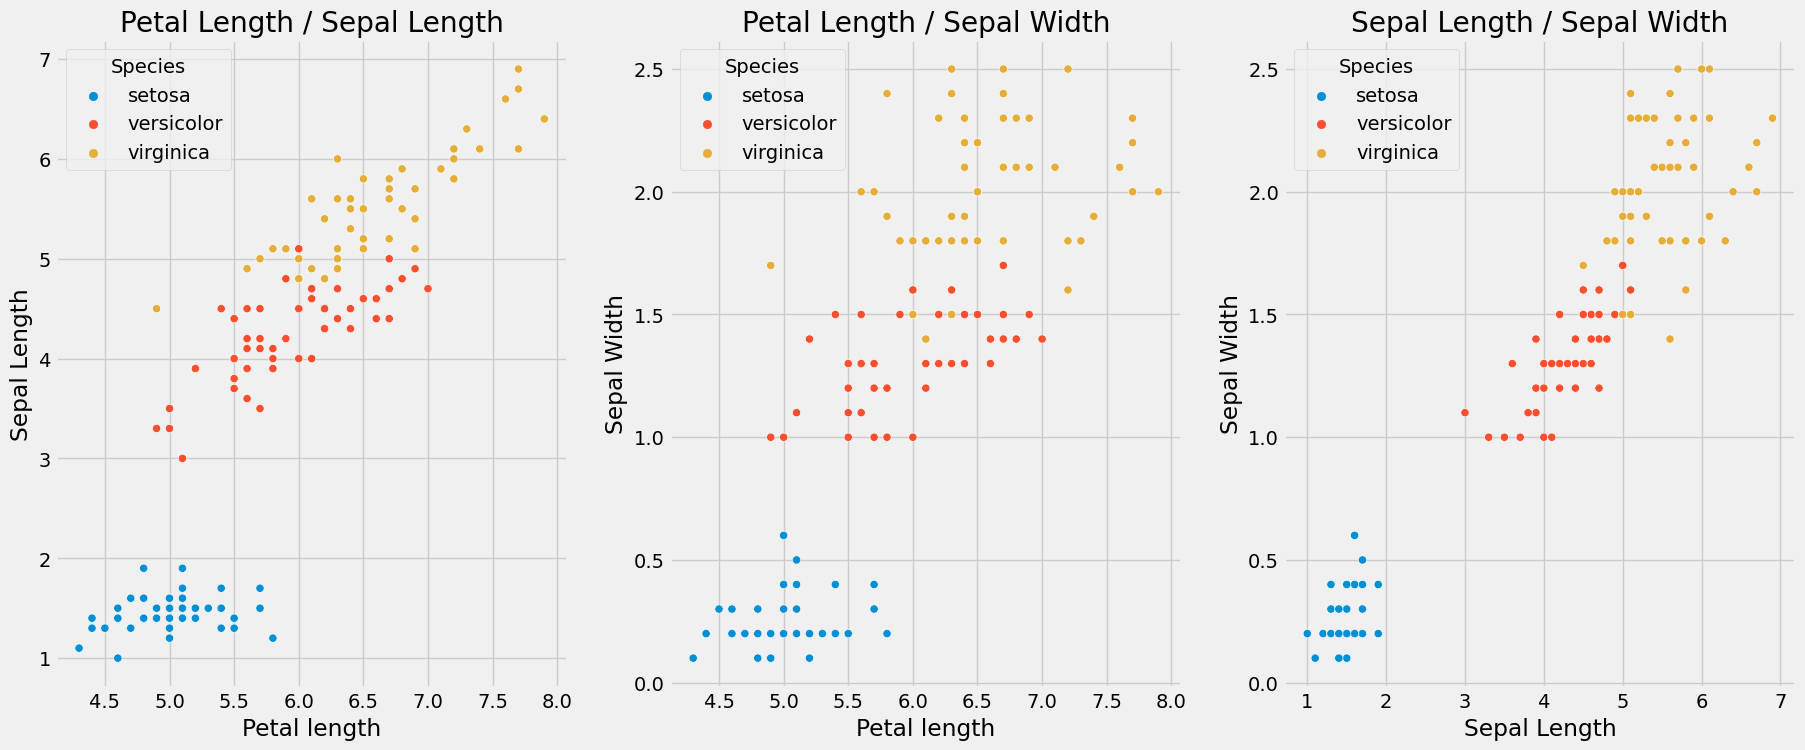

In [53]:
f, ax = plt.subplots(1, 3, figsize=(20, 8))

ax[0].set_title('Petal Length / Sepal Length')
sns.scatterplot(data=iris, x='Petal length', 
    y='Sepal Length', hue='Species', ax=ax[0]);

ax[1].set_title('Petal Length / Sepal Width')
sns.scatterplot(data=iris, x='Petal length', 
    y='Sepal Width', hue='Species', ax=ax[1]);

ax[2].set_title('Sepal Length / Sepal Width')
sns.scatterplot(data=iris, x='Sepal Length', 
    y='Sepal Width', hue='Species', ax=ax[2]);

__Conclusion :__

Pour les 3 corrélations, on peut voir que l'espèce *'Setosa'* est celle qui est la plus facilement identifiable. Elle a les plus petites pétales (en longueur), ainsi que pour la longueur et la largeur des sépales.  

On peut également noter que la *'Versicolor'* est presque au milieu en longueur et en largeur, là où, la *'Virginica'* a les sépales les plus longues et larges.  

Néanmoins, ces deux dernières (*'Versicolor'* et *'Virginica'*) sont plus ténues, et non pas une frontière visible qui marque une séparation nette. Elles partagent, ainsi, une certaines plages de données.

In [54]:
iris.groupby(['Species']).agg(['mean', 'median'])

Petal length        Petal Width        Sepal Length         \
                   mean median        mean median         mean median   
Species                                                                 
setosa            5.006    5.0       3.428    3.4        1.462   1.50   
versicolor        5.936    5.9       2.770    2.8        4.260   4.35   
virginica         6.588    6.5       2.974    3.0        5.552   5.55   

           Sepal Width         
                  mean median  
Species                        
setosa           0.246    0.2  
versicolor       1.326    1.3  
virginica        2.026    2.0

__Conclusion :__

Le tableau ci-dessous permet d'avoir une idée plus précise quant à la manière de distinguer les espèces.
En se basant sur la moyenne et la médiane, nous pouvons facilement appréhender les différences.  

Il est possible de voir ce tableau via un graphique et remarquer la densité des résultats sur chaque plage.

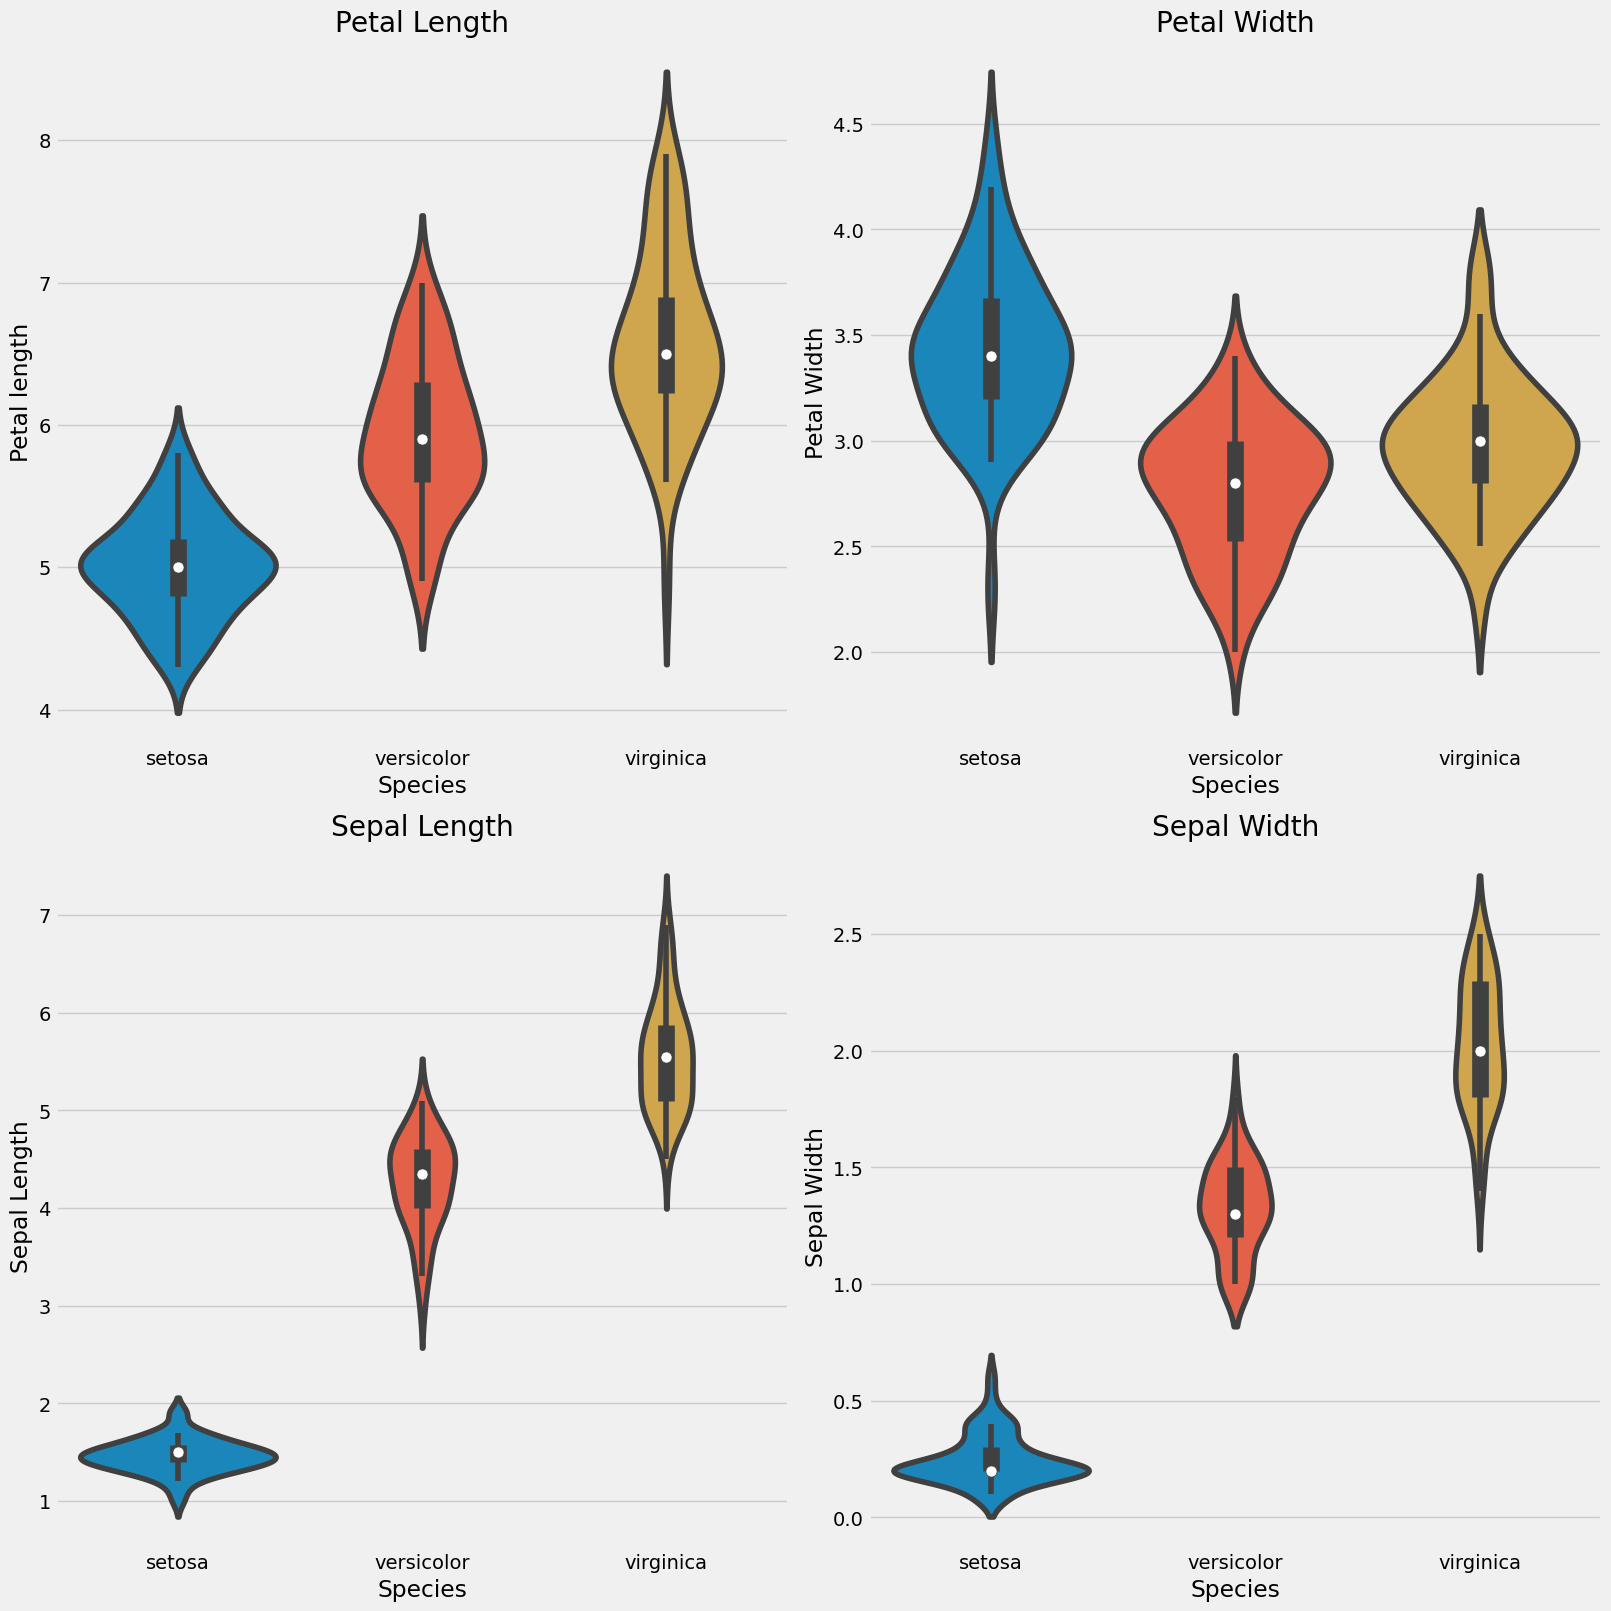

In [55]:
# Visualisation du tableau par violinplot :

f, ax = plt.subplots(nrows=2, ncols=2, figsize = (16,16), 
    constrained_layout=True)

ax[0][0].set_title('Petal Length')
sns.violinplot(data=iris, x='Species', y='Petal length', ax=ax[0][0]);

ax[0][1].set_title('Petal Width')
sns.violinplot(data=iris, x='Species', y='Petal Width', ax=ax[0][1]);

ax[1][0].set_title('Sepal Length')
sns.violinplot(data=iris, x='Species', y='Sepal Length', ax=ax[1][0]);

ax[1][1].set_title('Sepal Width')
sns.violinplot(data=iris, x='Species', y='Sepal Width', ax=ax[1][1]);

plt.show()

_______________________________
_______________________________

<center><h3>Machine Learning</h3></center>

#### Fractionnement de la dataset

In [56]:
# Encoding our target 'Species'
le = LabelEncoder()
iris.Species = le.fit_transform(iris.Species)

In [57]:
# Splitting the dataset : Features and Target
features = ['Petal length', 'Petal Width', 'Sepal Length', 'Sepal Width']
target = ['Species']

iris_Features = iris[features]
iris_Target = iris[target]

In [127]:
x_train, x_test, y_train, y_test = train_test_split(iris_Features, iris_Target, 
    train_size = 0.8)

print('Train set :', x_train.shape)
print('Test set :', x_test.shape)

Train set : (120, 4)
Test set : (30, 4)


________________________________________
#### Mise à l'échelle du dataset x_train

In [128]:
# Functions' instantiation
mms = MinMaxScaler()
rs = RobustScaler()
sc = StandardScaler()

# Application of a RobustScaler
keep_cols = ['Petal length', 'Petal Width', 'Sepal Length', 'Sepal Width']
x_train_scl = rs.fit_transform(x_train[keep_cols])
x_train_scl = pd.DataFrame(x_train_scl, columns=keep_cols)

# Application of a MinMaxScaler
x_train_scl = mms.fit_transform(x_train[keep_cols])
x_train_scl = pd.DataFrame(x_train_scl, columns=keep_cols)

# Application on the test rb then mms
x_test_scl = rs.transform(x_test[keep_cols])
x_test_scl = pd.DataFrame(x_test_scl, columns=keep_cols)

x_test_scl = mms.transform(x_test[keep_cols])
x_test_scl = pd.DataFrame(x_test_scl, columns=keep_cols)


###############################
# After Scaling Visualization #

# sns.scatterplot(data = x_train_scl)
# fig= plt.gcf()
# fig.set_size_inches(4,4)
# plt.show()

_______________________
#### Cross-validation

In [129]:
# Find the best cross-validation :
knn = KNeighborsClassifier()
kfold_score = loo_score = ss_score = stratkfold_score = []
cv_result = {'K-Fold':0.0, 
             'Shuffle Split':0.0, 
             'Strat K-Fold':0.0, 
             'LOOCV': 0.0}

k_range = range(1, 11)   # from 1 to 10 K-Nearest Neighbors
print("For 1 to 10 KNN : ")

# K-Fold
cv = KFold()
for k in k_range:
    score = cross_val_score(knn, x_train_scl, y_train, cv=cv, 
            scoring='accuracy').mean()
    kfold_score.append(score)
cv_result['K-Fold'] = mean(kfold_score)
print("    - K-Fold score max : ", max(kfold_score), "/ min :", 
    min(kfold_score))
print("    - K-Fold mean score : ", mean(kfold_score))

# Shuffle Split
cv = ShuffleSplit(n_splits=5, train_size=0.8)
for k in k_range:
    score = cross_val_score(knn, x_train_scl, y_train, cv=cv, 
            scoring='accuracy').mean()
    ss_score.append(score)
cv_result['Shuffle Split'] = mean(ss_score)
print("    - Shuffle Split score max : ", max(ss_score), 
    "/ min : ", min(ss_score))
print("    - Shuffle Split mean score : ", mean(ss_score))

# Stratified K-Fold
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
for k in k_range:
    score = cross_val_score(knn, x_train_scl, y_train, cv=cv, 
            scoring='accuracy').mean()
    stratkfold_score.append(score)
cv_result['Strat K-Fold'] = mean(stratkfold_score)
print("    - Stratified K-Fold score max : ", max(stratkfold_score), 
    "/ min : ", min(stratkfold_score))
print("    - Stratified K-Fold mean score : ", mean(stratkfold_score))

# leave One Out
cv = LeaveOneOut()
for k in k_range:
    score = cross_val_score(knn, x_train_scl, y_train.values.ravel(), cv=cv, 
            scoring='accuracy', n_jobs=-1).mean()
    loo_score.append(score)
cv_result['LOOCV'] = mean(loo_score)
print("    - LOOCV score max :", max(loo_score), "/ min : ", min(loo_score))
print("    - LOOCV mean score : ", mean(loo_score))

max_cv = max(cv_result, key=cv_result.get)
print("\n Best choice to select :", max_cv)

For 1 to 10 KNN : 
    - K-Fold score max :  0.9583333333333333 / min : 0.9583333333333333
    - K-Fold mean score :  0.9583333333333334
    - Shuffle Split score max :  0.975 / min :  0.9333333333333333
    - Shuffle Split mean score :  0.9570833333333335
    - Stratified K-Fold score max :  0.975 / min :  0.9333333333333333
    - Stratified K-Fold mean score :  0.9602777777777775
    - LOOCV score max : 0.975 / min :  0.9333333333333333
    - LOOCV mean score :  0.961875

 Best choice to select : LOOCV


In [130]:
# Select the best choice model according to previous result:
if max_cv == 'K-Fold':
    cv = KFold() 
elif max_cv == 'Shuffle Split':
    cv = ShuffleSplit(n_splits=5, train_size=0.8) 
elif max_cv == 'Strat K-Fold':
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
else:
    cv = LeaveOneOut()

______________________
#### Validation Curve

*NB : long si le modèle choisi est LOOCV (env. 3min 30sec)*

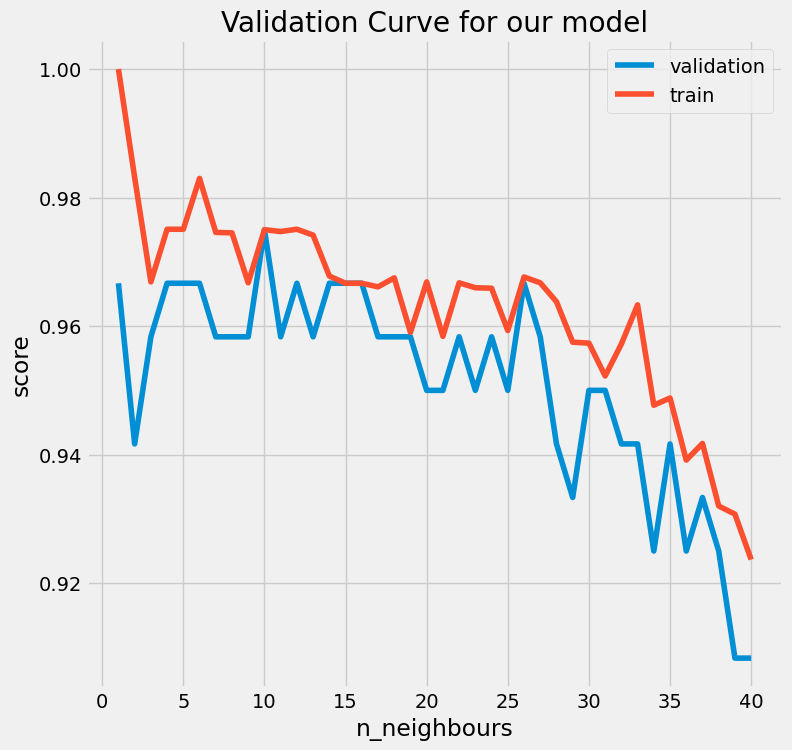

In [131]:
k = np.arange(1, 41) # From 1 to 40

# Validation Curve
train_score, val_score = validation_curve(knn, x_train_scl, y_train, 
    param_name='n_neighbors', param_range=k, cv=cv)

# Visualization
plt.figure(figsize=(8,8))
plt.title("Validation Curve for our model")
plt.plot(k, val_score.mean(axis=1), label='validation');
plt.plot(k, train_score.mean(axis=1), label='train');

plt.xlabel('n_neighbours')
plt.ylabel('score')
plt.legend()
plt.show()

________________________

#### GridSearchCV

In [132]:
# Dictionnary with our params
params = {'n_neighbors': np.arange(1,41),
                'metric': ['euclidean', 'manhattan']}

grid = GridSearchCV(knn, params, scoring='accuracy', cv=cv);
grid.fit(x_train_scl, y_train);

In [133]:
grid.best_score_

0.975

In [134]:
grid.best_params_

{'metric': 'euclidean', 'n_neighbors': 10}

In [135]:
model = grid.best_estimator_

model.score(x_test_scl, y_test)

0.9333333333333333

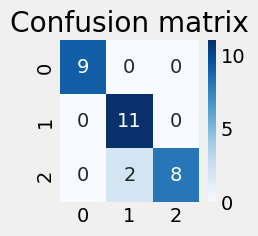

In [136]:
# Confusion Matrix
cf_matrix = confusion_matrix(y_test, model.predict(x_test_scl))

# Visualization
plt.figure(figsize=(2,2))
plt.title("Confusion matrix")
sns.heatmap(cf_matrix, cmap='Blues', annot=True);
plt.show()

______________________
#### Learning Curve

[ 11  23  35  47  59  71  83  95 107 119]


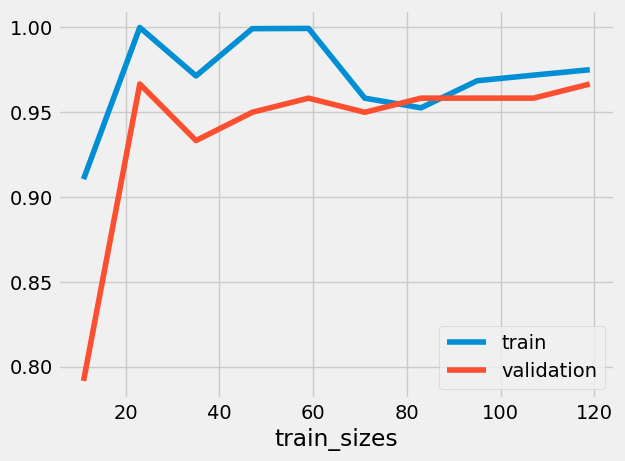

In [137]:
n, train_score, val_score = learning_curve(knn, x_train_scl, y_train, 
                            train_sizes=np.linspace(0.1, 1.0, 10), cv=cv)

print(n)
plt.plot(n, train_score.mean(axis=1), label='train')
plt.plot(n, val_score.mean(axis=1), label='validation')
plt.xlabel("train_sizes")
plt.legend()
plt.show()

______________________
______________________

<center><h2>The End</h2></center>